In [6]:
import numpy as np
import jax.numpy as jnp
from jax import lax
import jax

from jax import config
config.update("jax_enable_x64", True)

In [69]:

# note to self: wrap angles before passing to kepler solver? 
# add deep space logic and potentially error checks later

# ==============================================================================
# SGP4 CONSTANTS (WGS-72 / Appendix B)
# ==============================================================================

# could change this later so all constants are in caps to make code clearer? 

# Gravitational constants (WGS-72)
J2 = 1.082616e-3 # Unnormalised zonal harmonic coefficients
J3 = -0.253881e-5
J4 = -1.65597e-6
GM = 3.986008e5 # Earth gravitational parameter km^3/s^2
aE = 6378.135   # Earth equatorial radius in km 
ke = 60.0 / jnp.sqrt(aE**3 / GM)  # sqrt(GM) in units (Earth Radii)^1.5 / min)

# Derived constants (note: in normalised units as implied by paper i.e. aE = 1) 
k2 = 0.5 * J2 # (Earth Radii)^2 
A30 = -J3 # Normalized
k4 = -3/8 * J4 # Normalized

# Density constants
q0_val = 120.0  # km
s_val = 78.0    # km

In [70]:
from typing import NamedTuple

class Satellite(NamedTuple):
    n0: float      # Mean motion (revs/day)
    e0: float      # Eccentricity
    i0: float      # Inclination (degrees)
    w0: float      # Argument of perigee (degrees)
    Omega0: float  # Right ascension of the ascending node (degrees)
    M0: float      # Mean anomaly (degrees)
    Bstar: float   # Drag coefficient
    #t0: float      # Epoch time (minutes from some reference, usually not needed for relative calc)

def tle2sat(tle_1, tle_2):

    """
    Extract orbital elements from TLE (Two-Line Element) data and store them in a Satellite object.

    Inputs:
      tle_1 : str : First line of TLE
      tle_2 : str : Second line of TLE

    Returns:
      Satellite : NamedTuple containing orbital elements
    """
    # could add checks for valid TLE format later (as in original code)
    # there are also checks for non ascii characters in original code
    # just do necessary element extraction for now (could add e.g. satnum etc. later)

    # Extract elements from TLE strings
    n0 = float(tle_2[52:63])  # Mean motion (revs/day)
    e0 = float('0.' + tle_2[26:33].replace(' ', '0'))  # Eccentricity (not sure whether replace needed but it's in python sgp4)
    i0 = float(tle_2[8:16])  # Inclination (degrees)
    w0 = float(tle_2[34:42])  # Argument of perigee (degrees)
    Omega0 = float(tle_2[17:25])  # Right ascension of the ascending node (degrees)
    M0 = float(tle_2[43:51])  # Mean anomaly (degrees)

    Bstar = float(tle_1[53] + '.' + tle_1[54:59]) # Bstar mantissa
    bexp = int(tle_1[59:61])  # Exponent part of Bstar

    Bstar = Bstar * 10 ** bexp # Drag coefficient (Earth radii^-1) 

    return Satellite(n0, e0, i0, w0, Omega0, M0, Bstar)

# test
# TLE for the International Space Station (ZARYA)
tle1 = '1 25544U 98067A   25316.22557474  .00019835  00000-0  36009-3 0  9990'
tle2 = '2 25544  51.6334 293.5281 0004132  61.4658 298.6746 15.49560899538121' 

# Create Satrec object
from sgp4.api import Satrec
sat = Satrec.twoline2rv(tle1, tle2)

sat_test = tle2sat(tle1, tle2)

print(sat.no_kozai, sat_test.n0) # diff units
print(sat.ecco, sat_test.e0)
print(sat.inclo * 180.0 / jnp.pi, sat_test.i0)
print(sat.argpo * 180.0 / jnp.pi, sat_test.w0)
print(sat.nodeo * 180.0 / jnp.pi, sat_test.Omega0) # rounding error?
print(sat.mo * 180.0 / jnp.pi, sat_test.M0)
print(sat.bstar, sat_test.Bstar)    


0.06761234911928327 15.49560899
0.0004132 0.0004132
51.6334 51.6334
61.4658 61.4658
293.52809999999994 293.5281
298.6746 298.6746
0.00036009000000000003 0.00036009000000000003


In [71]:

#@jax.jit (commented this out to compare timings of jitted vs non-jitted)
def sgp4(sat: Satellite, tsince):
    """
    SGP4 propagation algorithm.
    
    Inputs:
      sat     : Satellite object containing orbital elements and parameters
      tsince  : Time since epoch (minutes)
      
    Returns:
      r       : Position vector [x, y, z] in km
      v       : Velocity vector [vx, vy, vz] in km/s
      (changed this to output concatenated array of r and v to make timing easier)
    """
    
    # --------------------------------------------------------------------------
    # A. INITIALIZATION
    # --------------------------------------------------------------------------
    
    # note to self: paper implicity uses units of Earth Radii for distance, minutes for time and radians 
    # for all internal calculations. (Output converted to km and km/s at end).

    # Unpack satellite parameters
    n0, e0, i0, w0, Omega0, M0, Bstar = sat
    
    # Convert inputs to radians
    i0 = jnp.radians(i0)
    w0 = jnp.radians(w0)
    Omega0 = jnp.radians(Omega0)
    M0 = jnp.radians(M0)
    
    # Convert Mean Motion from revs/day to rad/min
    n0_rad_min = n0 * (2 * jnp.pi) / 1440.0

    # Recover Brouwer mean motion from Kozai mean motion
    a1 = (ke / n0_rad_min) ** (2 / 3)
    
    # (Precompute trig) 
    cos_i0 = jnp.cos(i0)
    sin_i0 = jnp.sin(i0)
    theta = cos_i0
    theta2 = theta ** 2
    theta4 = theta ** 4
    
    delta1 = (1.5 * k2 * (3 * theta2 - 1)) / ((1 - e0 ** 2) ** 1.5 * a1 ** 2)
    a2 = a1 * (1 - delta1 / 3 - delta1 ** 2 - 134 / 81 * delta1 ** 3) 
    delta0 = (1.5 * k2 * (3 * theta2 - 1)) / ((1 - e0 ** 2) ** 1.5 * a2 ** 2)

    n0_brouwer = n0_rad_min / (1 + delta0)
    a0_brouwer = (ke / n0_brouwer) ** (2 / 3)

    # 1. Initialization for Secular Effects of Atmospheric Drag
    # ----------------------------------------------------------

    # Calculate epoch perigee height (in km)
    rp = (a0_brouwer * (1 - e0) - 1.0) * aE 
    
    # Logic for 's' parameter (in Earth Radii) based on perigee height
    s = lax.cond(
        rp >= 156,
        lambda rp: (s_val / aE) + 1.0,
        lambda rp: lax.cond(
            rp >= 98,
            lambda rp: (rp - s_val) / aE + 1.0,
            lambda rp: (20.0 / aE) + 1.0,
            rp
        ), 
        rp
    )
    
    # q0 parameter in Earth Radii
    q0 = (q0_val / aE) + 1.0

    xi = 1.0 / (a0_brouwer - s)
    beta0 = jnp.sqrt(1 - e0 ** 2)
    eta = a0_brouwer * e0 * xi
    
    # C2 Calculation
    term_c2_1 = a0_brouwer * (1 + 1.5 * eta ** 2 + 4 * e0 * eta + e0 * eta ** 3)
    term_c2_2 = (1.5 * k2 * xi / (1 - eta ** 2)) * (-0.5 + 1.5 * theta2) * (8 + 24 * eta ** 2 + 3 * eta ** 4)
    C2 = (q0 - s) ** 4 * xi ** 4 * n0_brouwer * (1 - eta ** 2) ** (-3.5) * (term_c2_1 + term_c2_2)
    
    C1 = Bstar * C2
    #CHECK whether this divide by zero check is nececessary / correct
    # C3 = jnp.where(e0 > 1e-4, 
    #                (q0 - s) ** 4 * xi ** 5 * A30 * n0_brouwer * sin_i0 / (k2 * e0), 
    #                0.0) # Avoid divide by zero for circular orbits
    C3 = (q0 - s) ** 4 * xi ** 5 * A30 * n0_brouwer * sin_i0 / (k2 * e0)

    # C4 Calculation
    term_c4_1 = 2 * eta * (1 + e0 * eta) + 0.5 * e0 + 0.5 * eta ** 3
    term_c4_2 = (2 * k2 * xi / (a0_brouwer * (1 - eta ** 2))) * \
                (3 * (1 - 3 * theta2) * (1 + 1.5 * eta ** 2 - 2 * e0 * eta - 0.5 * e0 * eta ** 3) + 
                 0.75 * (1 - theta2) * (2 * eta ** 2 - e0 * eta - e0 * eta ** 3) * jnp.cos(2 * w0))
    
    C4 = 2 * n0_brouwer * (q0 - s) ** 4 * xi ** 4 * a0_brouwer * beta0 ** 2 * \
         (1 - eta ** 2) ** (-3.5) * (term_c4_1 - term_c4_2)
         
    C5 = 2 * (q0 - s) ** 4 * xi ** 4 * a0_brouwer * beta0 ** 2 * \
         (1 - eta ** 2) ** (-3.5) * (1 + 2.75 * eta * (eta + e0) + e0 * eta ** 3)
         
    D2 = 4 * a0_brouwer * xi * C1 ** 2
    D3 = (4 / 3) * a0_brouwer * xi ** 2 * (17 * a0_brouwer + s) * C1 ** 3
    D4 = (2 / 3) * a0_brouwer ** 2 * xi ** 3 * (221 * a0_brouwer + 31 * s) * C1 ** 4

    # 2. Initialization for Secular Effects of Earth Zonal Harmonics
    # --------------------------------------------------------------

    Mdot = n0_brouwer * (3 * k2 * (-1 + 3 * theta2) / (2 * a0_brouwer ** 2 * beta0 ** 3) + 
                         3 * k2 ** 2 * (13 - 78 * theta2 + 137 * theta4) / (16 * a0_brouwer ** 4 * beta0 ** 7))
    
    wdot = n0_brouwer * (-3 * k2 * (1 - 5 * theta2) / (2 * a0_brouwer ** 2 * beta0 ** 4) + 
                         3 * k2 ** 2 * (7 - 114 * theta2 + 395 * theta4) / (16 * a0_brouwer ** 4 * beta0 ** 8) + 
                         5 * k4 * (3 - 36 * theta2 + 49 * theta4) / (4 * a0_brouwer ** 4 * beta0 ** 8))
                         
    Omegadot = n0_brouwer * (-3 * k2 * theta / (a0_brouwer ** 2 * beta0 ** 4) + 
                             3 * k2 ** 2 * (4 * theta - 19 * theta ** 3) / (2 * a0_brouwer ** 4 * beta0 ** 8) + 
                             5 * k4 * theta * (3 - 7 * theta2) / (2 * a0_brouwer ** 4 * beta0 ** 8))

    # 3. Initialization for Deep Space (Logic Hook)
    # Check for Deep Space (Period >= 225 minutes)
    period_min = 2 * jnp.pi / n0_rad_min
    is_deep_space = period_min >= 225.0
    
    # [ADDITION] Deep Space Initialization placeholder
    # In a full implementation, this calculates the Z-terms from Appendix A.
    # For this transcription, we initialize rates to zero unless detailed logic is added.
    # note to self: if deep space then not zero, else zero
    dot_M_LS = 0.0
    dot_w_LS = 0.0
    dot_Omega_LS = 0.0
    dot_e_LS = 0.0
    dot_i_LS = 0.0
    
    # If deep space logic were fully expanded here, we would populate the above variables
    # using the Z coefficients (Z1..Z33) and Lunar/Solar constants.

    # --------------------------------------------------------------------------
    # B. UPDATE
    # --------------------------------------------------------------------------
    
    # 1. Secular Update for Earth Zonal Gravity and Partial Atmospheric Drag Effects
    # ------------------------------------------------------------------------------

    MDF = M0 + (n0_brouwer + Mdot) * tsince
    wDF = w0 + wdot * tsince
    OmegaDF = Omega0 + Omegadot * tsince
    
    # Check for perigee height < 220 km for drag terms (will need to also add deep space check later)
    is_high_perigee = rp >= 220.0
    
    deltaw = lax.cond(
        is_high_perigee, 
        lambda _: Bstar * C3 * jnp.cos(w0) * tsince, 
        lambda _: 0.0,
        operand=None   
    )
    
    deltaM = lax.cond(
        is_high_perigee,
        lambda _: -2/3 * (q0 - s) ** 4 * Bstar * xi ** 4 / (e0 * eta) *
                  ((1 + eta * jnp.cos(MDF)) ** 3 - (1 + eta * jnp.cos(M0)) ** 3),
        lambda _: 0.0,
        operand=None
    )

    M_secular = MDF + deltaw + deltaM
    w_secular = wDF - deltaw - deltaM
    Omega_secular = OmegaDF - 21/2 * (n0_brouwer * k2 * theta / (a0_brouwer ** 2 * beta0 ** 2)) * C1 * tsince ** 2

    # 2. Secular Updates for Lunar and Solar Gravity (Deep Space)
    # --------------------------------------------------------------

    # [ADDITION] Apply the secular rates derived from Deep Space analysis
    # Note: These are 0.0 if period < 225 min
    M_secular += dot_M_LS * tsince
    w_secular += dot_w_LS * tsince
    Omega_secular += dot_Omega_LS * tsince
    e_secular = e0 + dot_e_LS * tsince
    i_secular = i0 + dot_i_LS * tsince

    # 3. Secular Updates for Resonance Effects of Earth Gravity
    # --------------------------------------------------------------
    # Add this later

    # 4. Secular Update for Remaining Atmospheric Drag Effects
    # --------------------------------------------------------------
    
    # Define time powers
    t2 = tsince ** 2
    t3 = tsince ** 3
    t4 = tsince ** 4

    # CHECK which terms to cut off for this condition? paper says 'linear' term which is ambiguous

    # Branch 1: High Perigee (>= 220km)
    def e_high(_):
        e = e_secular - Bstar * C4 * tsince - Bstar * C5 * (jnp.sin(M_secular) - jnp.sin(M0))
        a = (ke / n0_brouwer) ** (2/3) * (1 - C1 * tsince - D2 * t2 - D3 * t3 - D4 * t4) ** 2
        IL = M_secular + w_secular + Omega_secular + n0_brouwer * \
                 (1.5 * C1 * t2 + (D2 + 2 * C1 ** 2) * t3 + 
                  0.25 * (3 * D3 + 12 * C1 * D2 + 10 * C1 ** 3) * t4 + 
                  0.2 * (3 * D4 + 12 * C1 * D3 + 6 * D2 ** 2 + 30 * C1 ** 2 * D2 + 15 * C1 ** 4) * tsince ** 5)
        return e, a, IL
    
    # Branch 2: Low Perigee (< 220km)
    def e_low(_):
        e = e0 - Bstar * C4 * tsince
        a = (ke / n0_brouwer) ** (2/3) * (1 - C1 * tsince) ** 2
        IL = M_secular + w_secular + Omega_secular + n0_brouwer * \
                 (1.5 * C1 * t2 + (D2 + 2 * C1 ** 2) * t3 + 
                  0.25 * (3 * D3 + 12 * C1 * D2 + 10 * C1 ** 3) * t4)
        return e, a, IL
    
    # Select based on perigee condition
    e_final_sec, a_final_sec, IL = lax.cond(
        is_high_perigee, 
        e_high, 
        e_low,
        operand=None
    )

    # note to self: not sure whether to keep this? 
    # Enforce eccentricity limits (0 <= e < 1)
    #e_final_sec = jnp.clip(e_final_sec, 1e-6, 1.0 - 1e-6)
    
    # Calculate Mean Motion 'n' at time t
    n = ke / (a_final_sec ** 1.5)
    beta = jnp.sqrt(1 - e_final_sec ** 2)

    # 5. Update for Long-Period Periodic Effects of Lunar and Solar Gravity
    # ---------------------------------------------------------------------

    # add this later

    # 6. Update for Long-Period Periodic Effects of Earth Gravity
    # -----------------------------------------------------------

    # Calculate axN, ayN
    # Note: Phase 1 of long period periodics
    axN = e_final_sec * jnp.cos(w_secular)
    
    term_ill = (A30 * jnp.sin(i_secular)) / (8 * k2 * a_final_sec * beta ** 2)
    ILL = term_ill * axN * (3 + 5 * jnp.cos(i_secular)) / (1 + jnp.cos(i_secular))
    ayNL = A30 * jnp.sin(i_secular) / (4 * k2 * a_final_sec * beta ** 2)
    
    ILT = IL + ILL
    ayN = e_final_sec * jnp.sin(w_secular) + ayNL

    # 7. Update for Short-Period Periodic Effects of Earth Gravity
    # ------------------------------------------------------------
    
    # Solve Kepler's Equation for (E + w)
    # The variable U = M + w + Omega (modified) - Omega = M + w (? idk what this line is about)
    U = ILT - Omega_secular
    
    # Fixed-Point Iteration Solver for Kepler's Equation
    # We are solving for Ew = (E + w)
    # Iteration: Ew_new = Ew_old + Delta
    
    def kepler_body(i, Ew_curr):
        numerator = U - ayN * jnp.cos(Ew_curr) + axN * jnp.sin(Ew_curr) - Ew_curr
        denominator = 1 - ayN * jnp.sin(Ew_curr) - axN * jnp.cos(Ew_curr)
        return Ew_curr + numerator / denominator
    
    # Initial guess
    Ew_initial = U
    
    # Run 10 iterations
    Ew = lax.fori_loop(0, 10, kepler_body, Ew_initial)

    # sgp4 python also has a cut off if correction becomes negligibly small and a limit on step size
    # I could do this later but i think 10 iterations is fine for now
    # if I want to add cut off condition then use lax.while_loop instead

    # Calculate preliminary quantities for short-period periodics
    ecosE = axN * jnp.cos(Ew) + ayN * jnp.sin(Ew)
    esinE = axN * jnp.sin(Ew) - ayN * jnp.cos(Ew)
    
    e_osc = jnp.sqrt(ecosE ** 2 + esinE ** 2) # note to self: this is diff. to exact eq. in paper but gives same result
    #e_osc = jnp.clip(e_osc, 1e-6, 1.0 - 1e-6) # Safety clip - CHECK if needed later
    
    pL = a_final_sec * (1 - e_osc ** 2)
    r = a_final_sec * (1 - ecosE)
    
    rdot = ke * jnp.sqrt(a_final_sec) / r * esinE
    rfdot = ke * jnp.sqrt(pL) / r
    
    # Arguments of Latitude (u)
    # Note: e in the denominator term comes from the secular/long-period mix (e_osc logic)
    # The paper uses 'e' in the denominator term `1 + sqrt(1-e^2)`. 
    # Standard implementations use the osculating e here.
    cosu = (a_final_sec / r) * (jnp.cos(Ew) - axN + ayN * esinE / (1 + jnp.sqrt(1 - e_osc ** 2)))
    sinu = (a_final_sec / r) * (jnp.sin(Ew) - ayN - axN * esinE / (1 + jnp.sqrt(1 - e_osc ** 2)))
    u = jnp.arctan2(sinu, cosu)

    # Short-Period Corrections
    sin2u = jnp.sin(2 * u)
    cos2u = jnp.cos(2 * u)
    
    # Corrections (Deltas)
    # Using i_secular (mean inclination) for these factors
    sin_i = jnp.sin(i_secular)
    cos_i = jnp.cos(i_secular)
    
    Deltar = (k2 / (2 * pL)) * (1 - cos_i ** 2) * cos2u
    Deltau = (-k2 / (4 * pL ** 2)) * (7 * cos_i ** 2 - 1) * sin2u
    DeltaOmega = (3 * k2 * cos_i / (2 * pL ** 2)) * sin2u
    Deltai = (3 * k2 * cos_i / (2 * pL ** 2)) * sin_i * cos2u
    Deltardot = (-k2 * n / pL) * (1 - cos_i ** 2) * sin2u
    Deltarfdot = (k2 * n / pL) * ((1 - cos_i ** 2) * cos2u - 1.5 * (1 - 3 * cos_i ** 2))

    # Osculating Elements
    rk = r * (1 - 1.5 * k2 * jnp.sqrt(1 - e_osc ** 2) / (pL ** 2) * (3 * cos_i ** 2 - 1)) + Deltar
    uk = u + Deltau
    Omegak = Omega_secular + DeltaOmega
    ik = i_secular + Deltai
    rdotk = rdot + Deltardot
    rfdotk = rfdot + Deltarfdot

    # --------------------------------------------------------------------------
    # C. VECTORS (Position and Velocity)
    # --------------------------------------------------------------------------
    
    # Orientation Vectors (M and N)
    M = jnp.array([
        -jnp.sin(Omegak) * jnp.cos(ik), 
        jnp.cos(Omegak) * jnp.cos(ik), 
        jnp.sin(ik)
    ])

    N = jnp.array([
        jnp.cos(Omegak), 
        jnp.sin(Omegak), 
        0.0
    ])

    # Precompute trig
    sin_uk = jnp.sin(uk)
    cos_uk = jnp.cos(uk)

    # U and V vectors
    U = M * sin_uk + N * cos_uk
    V = M * cos_uk - N * sin_uk

    # Position and Velocity in TEME frame (Earth Radii and Earth Radii/min)
    # converted to output unit Distance = km, Velocity = km/s in one step
    r_vec = rk * U * aE
    v_vec = (rdotk * U + rfdotk * V) * aE / 60.0

    return jnp.concatenate((r_vec, v_vec))

    # # If output as separate r_vec, v_vec desired:
    #return r_vec, v_vec

In [72]:
# Test case

from sgp4.api import Satrec
from sgp4.api import jday

# TLE for the International Space Station (ZARYA)
tle1 = '1 25544U 98067A   25316.22557474  .00019835  00000-0  36009-3 0  9990'
tle2 = '2 25544  51.6334 293.5281 0004132  61.4658 298.6746 15.49560899538121' 

# Create Satrec object
sat = Satrec.twoline2rv(tle1, tle2)

# Choose a time since epoch to propagate to (minutes)
tsince = 500.0

# Propagate using standard SGP4 implementation
e, r, v = sat.sgp4_tsince(tsince)

print(r, v)  # position (km), velocity (km/s)
print("SGP4 error code:", e)

(705.08880216296, 5760.37365185177, 3527.6041455633244) (-5.192094694881382, 3.401162766577282, -4.496405865253736)
SGP4 error code: 0


In [73]:
# Propagate using JAX SGP4 implementation
satjax = tle2sat(tle1, tle2)

result = sgp4(satjax, tsince)
rjax = result[:3]
vjax = result[3:]

print(rjax, vjax)  # position (km), velocity (km/s)

[ 705.08880216 5760.37365185 3527.60414556] [-5.19209469  3.40116277 -4.49640587]


In [74]:
# Compare results
r = jnp.array(r)
v = jnp.array(v)
print(rjax - r)
print(vjax - v)

[ 5.50244295e-11 -3.63797881e-11  4.82032192e-11]
[9.76996262e-15 7.81597009e-14 4.79616347e-14]


In [7]:
# time sgp4 unjitted
%timeit sgp4(n0_test, e0_test, i0_test, w0_test, Omega0_test, M0_test, t0_test, Bstar_test, tsince).block_until_ready()

90.8 ms ± 3.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
# time sgp4 jitted
jaxsgp4 = jax.jit(sgp4)
%timeit jaxsgp4(n0_test, e0_test, i0_test, w0_test, Omega0_test, M0_test, t0_test, Bstar_test, tsince).block_until_ready()

14.9 μs ± 299 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
# time sgp4 python package C++ implementation

# (Verify it is using the fast C++ implementation rather than the slow python)
from sgp4.api import accelerated
print(accelerated)

%timeit sat.sgp4_tsince(tsince)

235 ns ± 3.93 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
# vectorise for one satellite over multiple times, many satellites over one time, many satellites over multiple times (do this later)...

# eventually can just integrate this with sgp4 function so a single function can handle all cases
def sgp4_many_times(sat: Satellite, tsince_array):
    """
    Vectorized SGP4 propagation over multiple times for a single satellite.
    
    Inputs:
      sat          : Satellite object containing orbital elements and parameters
      tsince_array : Array of times since epoch (minutes) jax or numpy both work?

    Returns:
      concatenated array of position and velocity vectors at each time in tsince_array (km and km/s)
    """

    jaxsgp4 = jax.jit(sgp4)

    # vectorize over tsince_array
    sgp4_vectorized = jax.vmap(jaxsgp4, in_axes=(None, 0))

    return sgp4_vectorized(sat, tsince_array)


In [25]:
# test propagation over multiple times

tsince_array = jnp.linspace(0, 1440, num=10000)  # 10 time points over one day
results_many_times = sgp4_many_times(satjax, tsince_array)

%timeit sgp4_many_times(satjax, tsince_array).block_until_ready()

1.51 ms ± 30.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
# convert array of times to jd, fr for sgp4 package
jd, fr = sat.jdsatepoch, sat.jdsatepochF
jd_array = jd + np.array(tsince_array) / 1440.0
fr_array = fr * np.ones_like(tsince_array)

# check results against sgp4 package
_, true_r_many_times, true_v_many_times = sat.sgp4_array(jd_array, fr_array)
print(true_r_many_times - results_many_times[:, :3])  # compare positions
print(true_v_many_times - results_many_times[:, 3:6])  # compare velocities

%timeit sat.sgp4_array(jd_array, fr_array)  # SGP4 C++ implementation for multiple times

[[ 5.00222086e-12  0.00000000e+00 -1.18546514e-12]
 [ 2.75313946e-05  1.25707866e-05  3.82526780e-05]
 [ 5.46753263e-05  2.60099077e-05  7.64944377e-05]
 ...
 [ 5.66430913e-05  2.13257745e-05  7.64600437e-05]
 [ 2.81623929e-05  1.11103855e-05  3.82194978e-05]
 [-7.27595761e-11 -3.00133252e-11 -9.22568688e-11]]
[[-1.77635684e-15  1.77635684e-15  8.88178420e-16]
 [-2.22695444e-08  5.03146462e-08 -4.21648494e-10]
 [-4.51437598e-08  1.00351676e-07 -1.68662240e-09]
 ...
 [-3.65384549e-08  1.03693559e-07 -2.02996464e-09]
 [-1.85786115e-08  5.17253844e-08 -1.43578216e-09]
 [ 4.79616347e-14 -1.28341782e-13  4.44089210e-15]]
1.36 ms ± 14.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


200 μs ± 3.09 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
778 ns ± 5.05 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
201 μs ± 2.28 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.9 μs ± 7.37 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
241 μs ± 2.63 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
14.9 μs ± 12.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
411 μs ± 3.28 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
149 μs ± 1.54 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.54 ms ± 25.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.36 ms ± 4.86 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


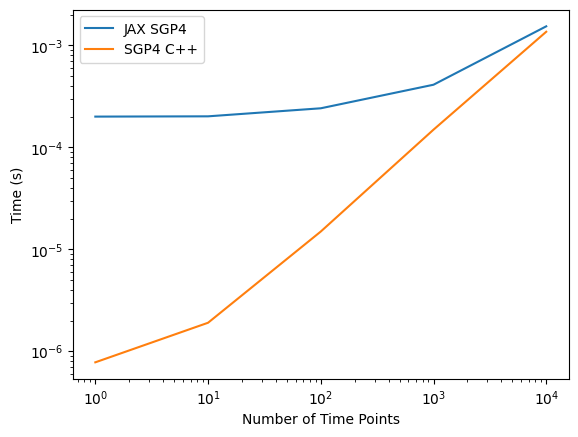

In [ ]:

# test over array 
jaxtimes = []
oldsgp4times = []
nums = []

for i in range(5):
  num = 10**i
  nums.append(num)
  tsince_array = jnp.linspace(0, 1440, num=num) 
  jaxtime = %timeit -o sgp4_many_times(n0_test, e0_test, i0_test, w0_test, Omega0_test, M0_test, t0_test, Bstar_test, tsince_array).block_until_ready()
  jaxtimes.append(jaxtime.average)
  jd_array = jd + np.array(tsince_array) / 1440.0
  fr_array = fr * np.ones_like(tsince_array)
  oldsgp4time = %timeit -o sat.sgp4_array(jd_array, fr_array)
  oldsgp4times.append(oldsgp4time.average)


In [ ]:
# Plot results

import matplotlib.pyplot as plt
plt.loglog(nums, jaxtimes, label='JAX SGP4')
plt.loglog(nums, oldsgp4times, label='SGP4 C++')
plt.xlabel('Number of Time Points')
plt.ylabel('Time (s)')
plt.legend()

In [ ]:


# maybe change this in the future so tle2sat can handle arrays directly?
def tle2sat_array(tle_1_array, tle_2_array):
    
    sats = [tle2sat(tle1, tle2) for tle1, tle2 in zip(tle_1_array, tle_2_array)]

    return Satellite(
        n0 = jnp.array([sat.n0 for sat in sats]),
        e0 = jnp.array([sat.e0 for sat in sats]),
        i0 = jnp.array([sat.i0 for sat in sats]),
        w0 = jnp.array([sat.w0 for sat in sats]),
        Omega0 = jnp.array([sat.Omega0 for sat in sats]),
        M0 = jnp.array([sat.M0 for sat in sats]),
        Bstar = jnp.array([sat.Bstar for sat in sats])
    )

def sgp4_many_sats(sat: Satellite, tsince):
    # fix what I named the function argument here
    """
    Vectorized SGP4 propagation over multiple satellites for a single time.

    Inputs:
      sat_array : Array of Satellite objects containing orbital elements and parameters
      tsince    : Time since epoch (minutes)

    Returns:
      concatenated array of position and velocity vectors for each satellite at time tsince (km and km/s)
    """
    
    jaxsgp4 = jax.jit(sgp4)

    # vectorize over sat_array
    sgp4_vectorized = jax.vmap(jaxsgp4, in_axes=(0, None))

    return sgp4_vectorized(sat, tsince)


In [ ]:
# test propagation over multiple satellites

# took raw gnss TLE data from https://celestrak.org/NORAD/elements/ which is in file gnss.txt 
# gnss actually doesn't work because these are deep space 
# use space stations instead gives 32 satellites to test with
# use starlink gives 9341 LEO sats to test with


# (use pkgutil get_data instead later if want to package this properly?)

# look at test_tle_export in python sgp4 for reference
with open('starlink.txt', 'r') as f:
    lines = iter(f.read().splitlines())
# check whether need ascii bit like tle_lines = iter(data.decode('ascii').splitlines()) in python sgp4

tle1_list = []
tle2_list = []

for line1 in lines:
    
    if not line1.startswith('1 '):
        continue 
        # note: Will get an error here if the satellite name starts with a '1 '

    line2 = next(lines)

    line1 = line1[:69]
    line2 = line2[:69]

    tle1_list.append(line1)
    tle2_list.append(line2)

print(f"Number of TLEs: {len(tle1_list)}")


Number of GNSS TLEs: 9341


In [113]:
# test for jax sgp4 multiple satellites 

sat_array_jax = tle2sat_array(tle1_list, tle2_list)

# Choose a time since epoch to propagate to (minutes)
tsince = 120.0
results_many_sats = sgp4_many_sats(sat_array_jax, tsince)

print(results_many_sats.shape)  # (num_sats, 6)
#%timeit sgp4_many_sats(sat_array_jax, tsince).block_until_ready()


(9341, 6)


In [114]:
# compare against python sgp4 package for multiple satellites SatrecArray
# (don't use this for timing as it's not the fast C++ implementation)
# just here to check against for correctness

true_results = []
for tle1, tle2 in zip(tle1_list, tle2_list):
    sat = Satrec.twoline2rv(tle1, tle2)
    e, r, v = sat.sgp4_tsince(tsince)
    true_results.append((*r, *v))

true_results = np.array(true_results)

# Compare
print(true_results[:, :3] - results_many_sats[:, :3])  # positions
print(true_results[:, 3:] - results_many_sats[:, 3:])  # velocities

[[-1.36424205e-12 -3.63797881e-12  0.00000000e+00]
 [-3.86535248e-12  0.00000000e+00  5.00222086e-12]
 [ 3.02406988e-10  8.50377546e-10  7.91260391e-11]
 ...
 [ 1.63709046e-11  2.72848411e-11  2.22826202e-11]
 [ 6.36646291e-12  1.68256520e-11  1.00044417e-11]
 [-5.45696821e-12  9.54969437e-12 -3.18323146e-12]]
[[ 8.88178420e-16 -2.66453526e-15 -3.99680289e-15]
 [-8.88178420e-16 -6.88338275e-15 -8.88178420e-16]
 [-5.91526828e-13  1.40332190e-13  7.96585020e-13]
 ...
 [-2.84217094e-14  2.93098879e-14 -1.77635684e-14]
 [-1.77635684e-14  1.15463195e-14 -1.19904087e-14]
 [-6.21724894e-15 -7.99360578e-15 -7.99360578e-15]]


In [106]:
# compare jitted vs unjitted to see if multiple satellite vetorisation is working 
%timeit sgp4_many_sats(sat_array_jax, tsince).block_until_ready()

#%timeit sgp4(sat_array_jax, tsince).block_until_ready() 
# actually this is quite complicated, maybe it's better to just make a graph of time for no of sats instead
# to see if it's working properly

264 μs ± 6.46 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
# see how time scales with number of satellites 

# test over array 
manysatjaxtimes = []
satnums = []

for i in range(4): # change this for starlink data
  num = 10**i
  satnums.append(num)
  tsince = 120.0 # choose arbitrary time
  jaxtime = %timeit -o sgp4_many_sats(sat_array_jax[:num], tsince).block_until_ready()
  manysatjaxtimes.append(jaxtime.average)

# Plot results
import matplotlib.pyplot as plt
plt.plot(satnums, manysatjaxtimes, label='JAX SGP4 Many Sats')
plt.xlabel('Number of Satellites')
plt.ylabel('Time (s)')
plt.legend()


ValueError: not enough values to unpack (expected 7, got 1)

In [58]:
# this doesn't really work as expected since sgp4 api SatrecArray.sgp4 expects to propagate all sats to same time

# # compare against python sgp4 package for multiple satellites SatrecArray
# from sgp4.api import SatrecArray

# sats = []
# jds = []
# frs = []
# for tle1, tle2 in zip(tle1_list, tle2_list):
#     sat = Satrec.twoline2rv(tle1, tle2)
#     sats.append(sat)
#     jds.append(sat.jdsatepoch)
#     frs.append(sat.jdsatepochF)

# sat_array = SatrecArray(sats)

# # want to propagate each satellite to tsince from its own epoch
# # expects jd, fr as numpy arrays even for a single time
# jd_array = np.array(jds) + tsince / 1440.0
# fr_array = np.array(frs)
# print(jd_array.shape, fr_array.shape)  # (num_sats,)

# _, true_r_many_sats, true_v_many_sats = sat_array.sgp4(jd_array, fr_array)
# print(true_r_many_sats.shape)  # (num_sats, 3)

# # Extract diagonal (satellite i at time i)
# diag_r = true_r_many_sats[jnp.arange(171), jnp.arange(171), :]
# diag_v = true_v_many_sats[jnp.arange(171), jnp.arange(171), :]

# print(diag_r - results_many_sats[:, :3])  # Should be small errors
# print(diag_v - results_many_sats[:, 3:6])



In [ ]:
# def sgp4_grid():

In [ ]:
# try on bigger dataset from data here https://celestrak.org/NORAD/elements/ look at active satellites 
# edit multiple sat thing to go to jd, fr directly rather than tsince
# side note for above: check naming conventions vs sgp4 package (e.g. sgp4 vs sgp4_tsince etc.)
# check whether i can actually vectorise over an object (claude said i can)